## Image labelling

In [119]:
import pathlib     # Library for file management
import imageio     # Reading and writing images
import numpy as np 

# Glob the training data into a variable (all the paths of the files)
trainingPaths = pathlib.Path('./Data/stage1_train').glob('*/images/*.png')
print(trainingPaths) #Note that it is an object from the library pathlib

trainingSorted = sorted([x for x in trainingPaths]) # Optional step
testImage1Path = trainingSorted[45] # Select one image
print(testImage1Path)

testImage1 = imageio.imread(str(testImage1Path)) #Need to convert the path into a string!

<generator object Path.glob at 0x110a571a8>
Data/stage1_train/10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28/images/10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28.png


## Dealing with colour images 

The images in this dataset can be in RGB, RGBA and grayscale format, based on the "modality" in which they are acquired. For color images, there is a third dimension which encodes the "channel" (e.g. Red, Green, Blue). To make things simpler for this first pass, we can coerce all these images into grayscale using the rgb2gray function from scikit-image.

In [120]:
# Print the image dimensions
print('Original image shape: {}'.format(testImage1.shape))

# Coerce the image into grayscale format (if not already)
from skimage.color import rgb2gray

testImage1Gray = rgb2gray(testImage1)
print('New image shape: {}'.format(testImage1Gray.shape))


Original image shape: (520, 696, 4)
New image shape: (520, 696)


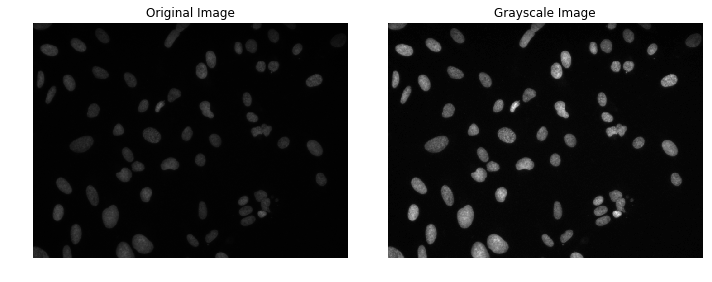

In [121]:
# Now, let's plot the data

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(testImage1)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(testImage1Gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

## Removing background

Perhaps the simplest approach for this problem is to assume that there are two classes in the image: objects of interest and the background. Under this assumption, we would expect the data to fall into a bimodal distribution of intensities. If we found the best separation value, we could "mask" out the background data, then simply count the objects we're left with.

The "dumbest" way we could find the threshold value would be to use a simple descriptive statistic, such as the mean or median. But there are other methods: the "Otsu" method is useful because it models the image as a bimodal distribution and finds the optimal separation value.

#### Otsu's method:

Method used to automatically perform clustering-based image thresholding <-> the reduction of a graylevel image to a binary image.

Otsu's method is roughly a one-dimensional, discrete analog of Fisher's Discriminant Analysis: The algorithm assumes that the image contains two classes of pixels following bi-modal histogram (foreground pixels and background pixels), it then calculates the optimum threshold separating the two classes so that their combined spread (intra-class variance) is minimal, or equivalently (because the sum of pairwise squared distances is constant), so that their inter-class variance is maximal.

In Otsu's method we exhaustively search for the threshold that minimizes the intra-class variance (the variance within the class), defined as a weighted sum of variances of the two classes:

$$\sigma^2_w(t)=\omega_0(t)\sigma^2_0(t)+\omega_1(t)\sigma^2_1(t)$$

Weights $\omega_{0}$ and $\omega_{1}$ are the probabilities of the two classes separated
by a threshold $t$ ,and $\sigma^2_{0}$ and $\sigma^2_{1}$ are variances of these two classes.

The class probability $\omega_{0,1}(t)$ is computed from the $L$ bins of the histogram:

$$ \begin{align}
\omega_0(t) & =\sum_{i=0}^{t-1} p(i)\\[4pt]
\omega_1(t) & =\sum_{i=t}^{L-1} p(i)
\end{align}
$$

Otsu shows that minimizing the intra-class variance is the same as maximizing inter-class variance:

$$
\begin{align}
\sigma^2_b(t) & =\sigma^2-\sigma^2_w(t)=\omega_0(\mu_0-\mu_T)^2+\omega_1(\mu_1-\mu_T)^2 \\
& =\omega_0(t) \omega_1(t) \left[\mu_0(t)-\mu_1(t)\right]^2
\end{align}
$$

which is expressed in terms of class probabilities $\omega$ and
class means $\mu$

while the class mean $\mu_{0,1,T}(t)$ is:

$$
\begin{align}
\mu_0(t) & =\sum_{i=0}^{t-1} i \frac{p(i)}{\omega_0} \\[4pt]
\mu_1(t) & =\sum_{i=t}^{L-1} i \frac{p(i)}{\omega_1} \\
\mu_T & = \sum_{i=0}^{L-1} ip(i)
\end{align}
$$

The following relations can be easily verified:

$$
\begin{align}
\omega_0\mu_0+\omega_1\mu_1 & = \mu_T \\
\omega_0+\omega_1 & =1
\end{align}
$$

The class probabilities and class means can be computed iteratively. This idea
yields an effective algorithm:

**Algorithm**:

- Compute histogram and probabilities of each intensity level
- Set up initial $\omega_i(0)$ and $\mu_i(0)$
- Step through all possible thresholds $t = 1, \ldots $ maximum intensity
- Update $\omega_i$ and $\mu_i$
- Compute $\sigma^2_b(t)$
- Desired threshold corresponds to the maximum $\sigma^2_b(t)$

In [122]:
from skimage.filters import threshold_otsu

thresh_val = threshold_otsu(testImage1Gray) #Apply Otsu's Method on the resulting gray image
mask = np.where(testImage1Gray > thresh_val, 1, 0) # True = 1, False = 0 (Mask <-> Boolean array)

# Make sure the larger portion of the mask is considered background
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

(361920,)


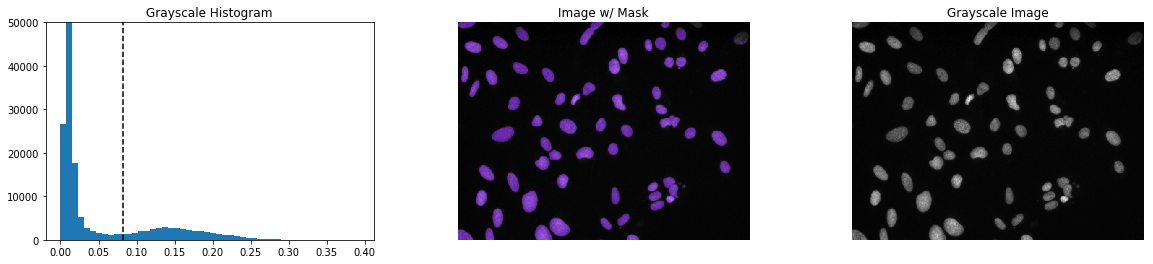

In [123]:
plt.figure(figsize=(20,4))

plt.subplot(1,3,1)
testImage1GrayPixels = testImage1Gray.flatten()
print(testImage1GrayPixels.shape)
plt.hist(testImage1GrayPixels,bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--')
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,3,2)
mask_for_display = np.where(mask, mask, np.nan)
plt.imshow(testImage1Gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')

plt.subplot(1,3,3)
plt.imshow(testImage1Gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')


plt.show()

#Works well with: 1, 45, 46
#Errors: Pictures with colour: Pictures 2, 3, 42, 

## Deriving individual masks for each object

For this contest, we need to get a separate mask for each nucleus. One way we can do this is by looking for all objects in the mask that are connected, and assign each of them a number using ndimage.label. Then, we can loop through each label_id and add it to an iterable, such as a list.

In [124]:
from scipy import ndimage

labels, nlabels = ndimage.label(mask)  #labels = labeled array; nlabels = number of labels

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)
    
#Store individual masks (one per label in label_arrays)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 76 separate components / objects detected.


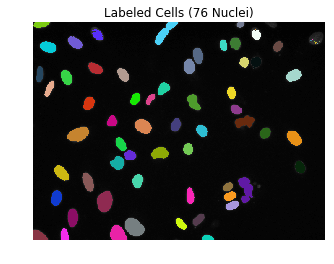

In [125]:
# Create a random colormap

from matplotlib.colors import ListedColormap

rand_cmap = ListedColormap(np.random.rand(256,3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(testImage1Gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

A quick glance reveals two problems (in this very simple image):

- There are a few individual pixels that stand alone (e.g. top-right)
- Some cells are combined into a single mask (e.g., top-middle)

Using `ndimage.find_objects`, we can iterate through our masks, zooming in on the individual nuclei found to apply additional processing steps.  `find_objects`` returns a list of the coordinate range for each labeled object in your image.

In [126]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)): #Input: labeled array, Output:
    print(label_ind)
    print(label_coords)
    cell = testImage1Gray[label_coords]
    print(cell)
    
    # Check if the label size is too small (less than a 10 pixel product!)
    if np.product(cell.shape) < 10: #np.product multiplies elements in an array
        print('Label {} is too small! Setting to 0.'.format(label_ind))  #label ind: 
        mask = np.where(labels==label_ind+1, 0, mask) #enumerate starts from 0! 

# Regenerate the labels
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

0
(slice(0, 14, None), slice(1, 40, None))
[[ 0.01176471  0.02745098  0.05098039  0.07058824  0.0745098   0.09019608
   0.09803922  0.10196078  0.09803922  0.09411765  0.09019608  0.09803922
   0.10196078  0.10196078  0.12156863  0.11764706  0.10980392  0.10980392
   0.10196078  0.10980392  0.10980392  0.11764706  0.12941176  0.11764706
   0.11764706  0.12941176  0.12156863  0.11764706  0.11372549  0.11764706
   0.12941176  0.13333333  0.12156863  0.10980392  0.09411765  0.09411765
   0.08627451  0.09019608  0.08235294]
 [ 0.02352941  0.05098039  0.0745098   0.07843137  0.08627451  0.10196078
   0.10588235  0.10588235  0.09803922  0.09411765  0.09803922  0.09803922
   0.10196078  0.11764706  0.11764706  0.12156863  0.1254902   0.11372549
   0.10980392  0.10588235  0.12156863  0.1254902   0.12156863  0.11764706
   0.11764706  0.1254902   0.1254902   0.12156863  0.10980392  0.11764706
   0.12156863  0.12941176  0.11372549  0.10588235  0.09803922  0.09803922
   0.09411765  0.08627451  0.0

Label 14 is too small! Setting to 0.
15
(slice(44, 45, None), slice(661, 664, None))
[[ 0.08235294  0.08627451  0.08235294]]
Label 15 is too small! Setting to 0.
16
(slice(44, 47, None), slice(670, 672, None))
[[ 0.07843137  0.08235294]
 [ 0.08235294  0.08627451]
 [ 0.08235294  0.0745098 ]]
Label 16 is too small! Setting to 0.
17
(slice(46, 74, None), slice(16, 56, None))
[[ 0.01176471  0.01176471  0.01176471 ...,  0.00784314  0.00392157
   0.00392157]
 [ 0.00784314  0.01176471  0.01568627 ...,  0.00784314  0.00784314
   0.00784314]
 [ 0.01176471  0.01568627  0.01568627 ...,  0.00784314  0.00784314
   0.00784314]
 ..., 
 [ 0.00784314  0.00784314  0.00784314 ...,  0.02745098  0.02352941
   0.01568627]
 [ 0.00784314  0.00784314  0.00784314 ...,  0.01960784  0.01568627
   0.01568627]
 [ 0.00784314  0.00784314  0.00784314 ...,  0.01568627  0.01568627
   0.01176471]]
18
(slice(46, 71, None), slice(573, 595, None))
[[ 0.00784314  0.00784314  0.01176471  0.01176471  0.01568627  0.01568627
   

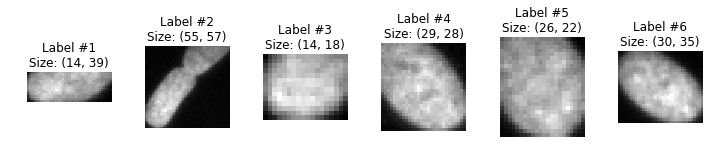

In [127]:
fig, axes = plt.subplots(1,6, figsize=(10,6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:6]):
    cell = testImage1Gray[obj_indices]  #ndimage.find_objects gives the coordinates for doing a zoom where 
    #there is an object
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

Label #2 has the "adjacent cell" problem: the two cells are being considered part of the same object. One thing we can do here is to see whether we can shrink the mask to "open up" the differences between the cells. This is called mask erosion. We can then re-dilate it to to recover the original proportions.

In [144]:
two_cell_indices = ndimage.find_objects(labels)[1] #Zoom object of interest: This time, second one!
cell_mask = mask[two_cell_indices] 
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8)

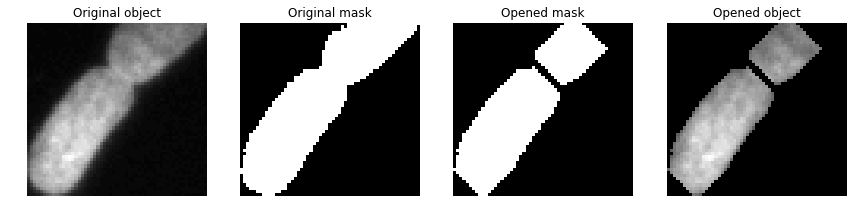

In [145]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(testImage1Gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(testImage1Gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')


for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

#### Convert each labeled object to Run Line Encoding 

RLE (Run Length Encoding) is the format that the contest submission requires - it's a way to more efficiently encode the locations of masks for each image. Basically, instead of encoding the mask value (0/1) for every location in the image, we assume that every value is zero EXCEPT the ones we explicitly state. So, if a mask contains only 10 "positive" pixels, and they start at the 100th pixel and are all consecutive, we could encode this as: 100 10. If we uploaded a numpy array, we would be encoding many more values, e.g. 128*128 values in an image of that size.

Finally, we need to encode each label_mask into a "run line encoded" string. Basically, we walk through the array, and when we find a pixel that is part of the mask, we index it and count how many subsequent pixels are also part of the mask. We repeat this each time we see new pixel start point.

I found a nice function to do RLE from Kaggle user Rakhlin's kernel, which I've copied here.

In [146]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 210075 6 210593 8 211112 9 211631 10 212150 11 212669 12 213189 12 213709 12 214228 13 214748 13 215268 13 215788 13 216308 13 216828 13 217348 13 217869 12 218389 12 218909 12 219430 11 219950 11 220471 10 220991 10 221512 9 222033 8 222554 7 223075 6 223596 5 224117 4 224639 2


## Combine it into a single function 

In [147]:
import pandas as pd

def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = imageio.imread(str(im_path))
    im_gray = rgb2gray(im)
    
    # Mask out background and extract connected objects
    thresh_val = threshold_otsu(im_gray)
    mask = np.where(im_gray > thresh_val, 1, 0)
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df


def analyze_list_of_images(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [148]:
testing = pathlib.Path('./Data/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submission.csv', index=None)